Size: 32
Exponential Fitted s: 33.54, Log loss: 0.505426
Power Fitted s: 21.64, decay: -0.08, Log loss: 0.484114
Size: 64
Exponential Fitted s: 49.94, Log loss: 0.389263
Power Fitted s: 70.40, decay: -0.33, Log loss: 0.374649
Size: 128
Exponential Fitted s: 78.10, Log loss: 0.284641
Power Fitted s: 60.66, decay: -0.01, Log loss: 0.278082
Size: 256
Exponential Fitted s: 107.68, Log loss: 0.293584
Power Fitted s: 120.78, decay: -0.23, Log loss: 0.293191
Size: 512
Exponential Fitted s: 95.92, Log loss: 0.332563
Power Fitted s: 95.40, decay: -0.87, Log loss: 0.332563
Size: 1024
Exponential Fitted s: 103.03, Log loss: 0.317877
Power Fitted s: 103.31, decay: -0.33, Log loss: 0.317835
Size: 2048
Exponential Fitted s: 105.92, Log loss: 0.311954
Power Fitted s: 106.25, decay: -1.00, Log loss: 0.311960
Size: 4096
Exponential Fitted s: 103.56, Log loss: 0.316163
Power Fitted s: 103.79, decay: -1.00, Log loss: 0.316178
Size: 8192
Exponential Fitted s: 101.64, Log loss: 0.320569
Power Fitted s: 101

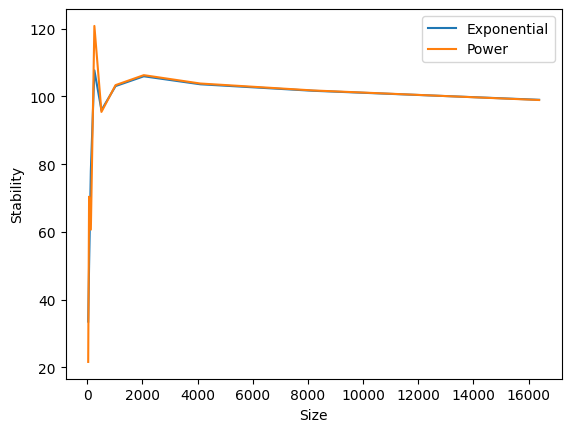

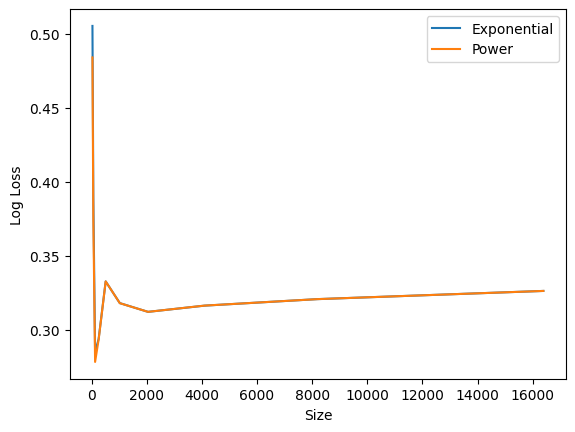

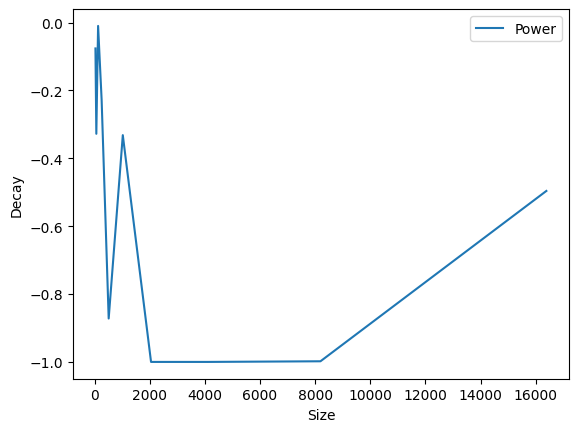

In [1]:
import numpy as np
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn import BCELoss
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

s = 100
LEARNING_RATE = 1
BATCH_SIZE = 32
NUM_EPOCHS = 1024
GAMMA = 0.9999


def exp_forgetting_curve(t, s):
    return torch.pow(0.9, t / s)


def power_forgetting_curve(t, s, decay):
    factor = 0.9 ** (1 / decay) - 1
    return (1 + factor * t / s) ** decay


def get_mini_batches(t, y, batch_size):
    indices = np.random.permutation(len(t))
    for i in range(0, len(t), batch_size):
        batch_indices = indices[i : i + batch_size]
        yield t[batch_indices], y[batch_indices]


def fit_exp_forgetting_curve(
    t, y, learning_rate=LEARNING_RATE, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE
):
    t = torch.tensor(t, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    # Initialize parameter
    stability = torch.tensor(1.0, requires_grad=True)
    optimizer = Adam([stability], lr=learning_rate)
    scheduler = ExponentialLR(optimizer, gamma=GAMMA)
    loss_fn = BCELoss()

    for epoch in range(num_epochs):
        epoch_loss = 0
        num_batches = 0

        # Mini-batch training
        for t_batch, y_batch in get_mini_batches(t, y, batch_size):
            # Forward pass
            y_pred = exp_forgetting_curve(t_batch, stability)
            loss = loss_fn(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update parameter
            optimizer.step()
            scheduler.step()
            stability.data.clamp_(0.01, 36500)

            epoch_loss += loss.item()
            num_batches += 1

    return stability.item()


def fit_power_forgetting_curve(
    t, y, learning_rate=LEARNING_RATE, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE
):
    t = torch.tensor(t, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    # Initialize parameters
    stability = torch.tensor(1.0, requires_grad=True)
    decay = torch.tensor(-0.5, requires_grad=True)
    optimizer = Adam([stability, decay], lr=learning_rate)
    scheduler = ExponentialLR(optimizer, gamma=GAMMA)
    loss_fn = BCELoss()

    for epoch in range(num_epochs):
        epoch_loss = 0
        num_batches = 0

        # Mini-batch training
        for t_batch, y_batch in get_mini_batches(t, y, batch_size):
            # Forward pass
            y_pred = power_forgetting_curve(t_batch, stability, decay)
            loss = loss_fn(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update parameters
            optimizer.step()
            scheduler.step()
            stability.data.clamp_(0.01, 36500)
            decay.data.clamp_(-1.0, -0.01)

            epoch_loss += loss.item()
            num_batches += 1

    return stability.item(), decay.item()


exp_s = []
power_s = []
exp_losses = []
power_losses = []
power_decays = []
sizes = [2**i for i in range(5, 15)]
for size in sizes:
    print(f"Size: {size}")

    t_sample = np.random.randint(90, 110, size)
    t_sample.sort()

    p = exp_forgetting_curve(torch.tensor(t_sample, dtype=torch.float32), s).numpy()
    y_sample = np.random.binomial(1, p)

    # Fit the exponential forgetting curve
    s_fit = fit_exp_forgetting_curve(t_sample, y_sample, batch_size=min(32, size))
    # Calculate the fitted values
    p_fit = exp_forgetting_curve(
        torch.tensor(t_sample, dtype=torch.float32), s_fit
    ).numpy()
    # Calculate the log loss
    loss = log_loss(y_sample, p_fit)
    print(f"Exponential Fitted s: {s_fit:.2f}, Log loss: {loss:.6f}")
    exp_s.append(s_fit)
    exp_losses.append(loss)

    # Fit the power forgetting curve
    s_fit_power, decay_fit = fit_power_forgetting_curve(
        t_sample, y_sample, batch_size=min(32, size)
    )
    # Calculate the fitted values
    p_fit_power = power_forgetting_curve(
        torch.tensor(t_sample, dtype=torch.float32), s_fit_power, decay_fit
    ).numpy()
    # Calculate the log loss
    loss_power = log_loss(y_sample, p_fit_power)
    print(
        f"Power Fitted s: {s_fit_power:.2f}, decay: {decay_fit:.2f}, Log loss: {loss_power:.6f}"
    )
    power_s.append(s_fit_power)
    power_decays.append(decay_fit)
    power_losses.append(loss_power)

plt.plot(sizes, exp_s, label="Exponential")
plt.plot(sizes, power_s, label="Power")
plt.xlabel("Size")
plt.ylabel("Stability")
plt.legend()
plt.show()

plt.plot(sizes, exp_losses, label="Exponential")
plt.plot(sizes, power_losses, label="Power")
plt.xlabel("Size")
plt.ylabel("Log Loss")
plt.legend()
plt.show()

plt.plot(sizes, power_decays, label="Power")
plt.xlabel("Size")
plt.ylabel("Decay")
plt.legend()
plt.show()